# Attempt 1 (Quantization here, training in quantize_2)

In [81]:
# Quantization code from Song Han's TinyML class
import torch

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

In [82]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max()
    fp_min = fp_tensor.min()

    # scale
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # zero_point
    zero_point = ((quantized_min - fp_min / scale))

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

In [83]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=np.int8) -> np.array:
    """
    linear quantization for single fp_tensor
      from
        r = fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        q = quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [np.array] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [float] scaling factor
    :param zero_point: [int] the desired centroid of tensor values
    :return:
        [np.array] quantized tensor whose values are integers
    """
    # assert(fp_tensor is np.array)
    assert(isinstance(scale, float))
    assert(isinstance(zero_point, int))

    # scale the fp_tensor
    scaled_tensor = fp_tensor/scale
    # round the floating value to integer value
    rounded_tensor = (np.round(scaled_tensor)) #.to(torch.int8)

    # print(rounded_tensor.dtype)

    # shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point

    # clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clip(quantized_min, quantized_max)
    quantized_tensor = quantized_tensor.astype(np.int8)
    return quantized_tensor

In [84]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

In [221]:
checkpoint = torch.load("./NN/MNIST_3.pt")

weights_biases = {}

for name, param in checkpoint.items():
    weights_biases[name] = param.cpu().numpy()  # Convert to numpy array and store

int8_quant = {}

for key in weights_biases:
    print(key)
    int8_quant[key] = linear_quantize_feature(weights_biases[key], 8)[0]
    print(int8_quant[key])

fc1.weight
[[  0  -8   6 ...  -2 -14  13]
 [  1   5   4 ...   0 -12  11]
 [ -6   4  -5 ... -14  -1  -8]
 ...
 [  9  -3   5 ... -12   5  12]
 [  1  -9  -7 ...   6   5   4]
 [ -2  -2  -7 ...  -5   7  -2]]
fc1.bias
[ 108   32   89  -55   68   23   -4 -128   34  127]
fc2.weight
[[   8   16   22   85  -25  -10   37  -58   -3 -128]
 [  37  -63  -29  -87   -8   92  -72 -102  -57   49]
 [  12  -34  -32  -85  -84   38   74  -73  -91 -101]
 [  20   31   81  -18  -45  -79   58   -9  -20  -42]
 [  79  -26   57 -102    7  -87   70  -52   22  127]
 [  -2  -65  -86  -19  101  -79   21   48  -57  -17]
 [  46   -1   47  -23  111   21 -102  -49   54  -87]
 [   9   32   28  -88  -34   65   18   63   72   -1]
 [  46   55  -14   32  -49   30   61  -64   66  -20]
 [  90  -89  -15  -21   42  -44   60   67   29  -51]]
fc2.bias
[  76  127   35  -72  -35   45   12 -128   21   86]
fc3.weight
[[  36  -96   81   35  -30   27  -60   32  -30   56]
 [ -71   12  -47  -43  -38  -56    6   27  -59 -125]
 [  33   48   56

In [222]:
def run_nn(input):
    layer1 = np.dot(weights_biases["fc1.weight"], input) + weights_biases["fc1.bias"]
    layer2 = np.dot(weights_biases["fc2.weight"], layer1) + weights_biases["fc2.bias"]
    return np.argmax(layer2)

def run_quantized_nn(input):
    layer1 = np.dot(int8_quant["fc1.weight"], input) + int8_quant["fc1.bias"]
    layer2 = np.dot(int8_quant["fc2.weight"], layer1) + int8_quant["fc2.bias"]
    return np.argmax(layer2)

In [223]:
def convert_img_to_numpy_arr(fp):
  img = Image.open(fp)

  # Convert the image to grayscale
  img = img.convert("L")

  pixel_values = np.array(img)

  img_flattened = pixel_values.reshape(-1)

  img_flattened = [0 if x > 127 else 1 for x in img_flattened]

  return np.array(img_flattened)

In [224]:
def display_image(img_flat):
    for i in range(1):
        flattened_tensor = img_flat  # Replace with your actual data

        # Reshape to 28 x 28
        image_tensor = flattened_tensor.reshape(28, 28)  # or .reshape(28, 28)

        # Plot the image
        plt.imshow(image_tensor, cmap="gray")
        plt.colorbar()  # Optional: to show the color scale
        plt.show()

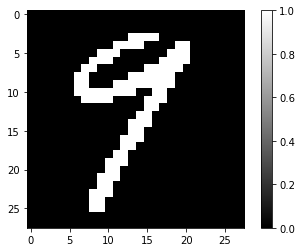

1


1

In [225]:
fp = "./images/9.png"

flat_image = convert_img_to_numpy_arr(fp)
display_image(flat_image)
print(run_nn(flat_image))
run_quantized_nn(flat_image)

In [237]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize to standard MNIST mean and std
    transforms.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(0.0))),
    transforms.Lambda(lambda x: x.view(-1))
])

# Download and load the MNIST dataset
test_dataset = datasets.MNIST(root='../data', train=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

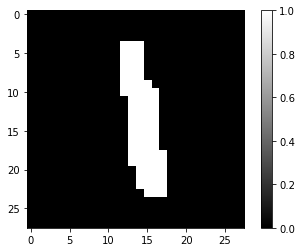

1


1

In [244]:
img = test_dataset[6][0]
display_image(img)
print(run_nn(img))
run_quantized_nn(img)

In [ ]:
# Attempt 2

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return output